<a href="https://colab.research.google.com/github/armitakar/GGS366_Spatial_Computing/blob/main/Lectures/8_1_Point_pattern_analysis_Centrography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **spatial point pattern** refers to the distribution of objects (e.g., buildings, trees, schools) or events (e.g., crashes, crimes, and geotagged tweets) within space. These points can sometimes be: **unmarked** (only have loction information) or **marked** (contains locational and additional attribute information, such as time and description of the events)

With **point pattern analysis**, we visualize, summarize and model the point patterns. In this lecture, we will discuss **Centrography**, which, in essence, calculates summary statistics, such as **mean center, standarad distance and standard deviational ellipse** from the point data.

Further reading:
- https://mgimond.github.io/Spatial/chp11_0.html#centrography
- https://pysal.org/notebooks/explore/pointpats/centrography.html
- https://github.com/pysal/pointpats/blob/main/notebooks/centrography.ipynb
- https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html

# Library

Import all necessary libraries.

In [ ]:
# we will use this library to load base maps
!pip install contextily

In [ ]:
# we will use this package to perform point pattern analysis
# package developed by pySAL (Python Spatial Analysis) library
!pip install pointpats

In [ ]:
# libraries for reading and processing the spatial data
import pandas as pd
import geopandas as gpd

# libraries for calculating the summary statistics
import numpy as np
from pointpats import centrography

# libraries for visualiations
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle, Rectangle, Ellipse
import contextily as cx

# Data

We will use the Virginia crash data for this lecture. We retrieve the data from here: https://www.virginiaroads.org/datasets/VDOT::crashdata-basic-1/explore

Please note that there is a default query limit when we directly request data from the ArcGIS Server (typically 2000 records returned in a single request).

To retrieve all data, we can use [Pagination](https://medium.com/@jesse.b.nestler/how-to-extract-every-feature-from-an-esri-map-service-using-python-b6e34743574a). In this approach, we will retrieve data in batches using the **resultOffset** and **resultRecordCount** parameters. we can also filter the data while extracting. For instrance, we can query for year-specific crash data with the code below:



In [ ]:
import requests

# Base URL for the FeatureServer
base_url = "https://services.arcgis.com/p5v98VHDX9Atv3l7/arcgis/rest/services/CrashData_test/FeatureServer/0/query"

# Function to fetch data in batches
def fetch_all_data(year, data_crs):
    all_data = []
    offset = 0
    batch_size = 2000  # ArcGIS default max

    while True:
        params = {
            "outFields": "*",
            "where": f"CRASH_YEAR = {year}",
            "f": "geojson",
            "resultOffset": offset,
            "resultRecordCount": batch_size
        }

        response = requests.get(base_url, params=params)

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        data = response.json()

        # Convert to GeoDataFrame and append
        gdf = gpd.GeoDataFrame.from_features(data["features"])
        all_data.append(gdf)

        # If fewer records returned than batch size, stop
        if len(gdf) < batch_size:
            break

        offset += batch_size  # Move to the next batch
    final_df = pd.concat(all_data, ignore_index=True)
    final_gdf = gpd.GeoDataFrame(final_df, geometry='geometry', crs=data_crs) # make sure to check the crs from metadata
    return final_gdf

In [ ]:
# Loading all crash data
crash = fetch_all_data(2022, 4326)

# Checking total records loaded
print(f"Total records loaded: {len(crash)}")

# Removing any null geometries
crash = crash.dropna(subset=['geometry'])

# Converting to projected CRS for accurate distance measures
crash = crash.to_crs(epsg = 3857)

Total records loaded: 122434


# Visualization

With any point pattern data, we can create scatterplots.

Text(116.47222222222221, 0.5, 'Latitude')

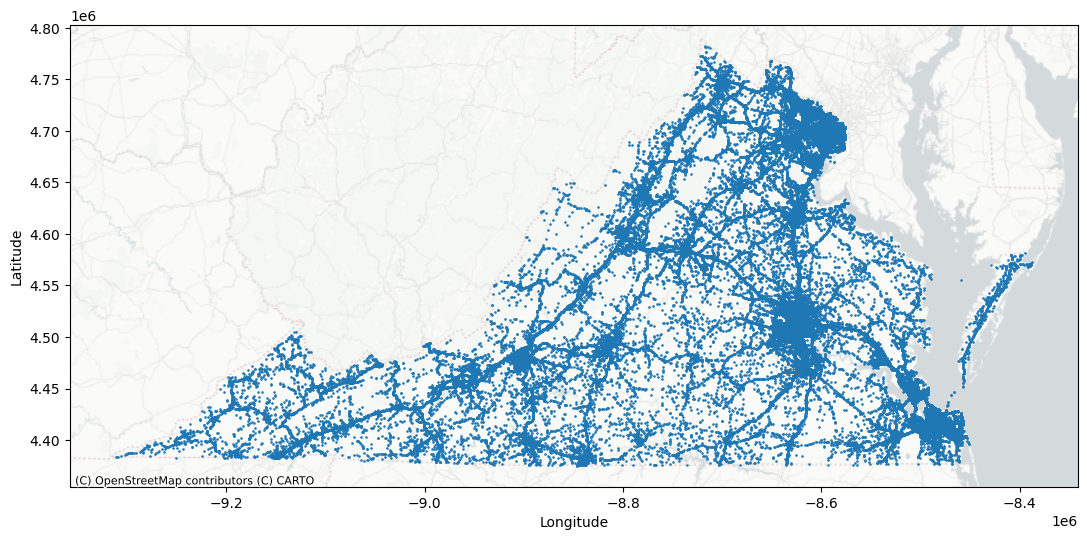

In [ ]:
# Setting up figure and axes
fig, ax = plt.subplots(figsize=(13, 6))

# Plotting the crash points
ax.scatter(x=crash.geometry.x, # extracting longitude from crash geometry
           y=crash.geometry.y, # extracting latitude from crash geometry,
           s=0.75)             # setting the size of the points

# Adding basemap from the contextily library (loaded as cx)
cx.add_basemap(
    ax =ax,
    crs="EPSG:3857",
    source=cx.providers.CartoDB.PositronNoLabels,
);

# Adding x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Centrography

Centrography provides a way to summarize the spatial distribution of point patterns by estimating their **central tendency, dispersion, orientation, and extent** using various statistical measures.

![image](https://mgimond.github.io/Spatial/img/centrography.svg)

We will use the [Centrography](https://github.com/pysal/pointpats/blob/main/notebooks/centrography.ipynb) module of [pointpats](https://github.com/pysal/pointpats?tab=readme-ov-file) package. This package is part of [PySAL](https://pysal.org/): The Python Spatial Analysis Library.

### Central tendency

The most common measure of central tendency is the **mean center**, which is equivalent to finding mean for any dataset.

- For **unmarked** point patterns, the **mean center** is simply the **arithmetic mean** of the coordinate values.
- For **marked** point patterns, a **weighted mean center** is used. We calculate weighted mean center by assigning weights to each point location based on a specific attribute (e.g., crash locations weighted by number of people injured). The weighted mean center tends to be near point locations with higher attribute values.

![image](https://miro.medium.com/v2/resize:fit:600/1*y-v_XXBoGRq3Grhc8bVWTA.jpeg)

Equations for weighted mean center can be found here: https://pysal.org/notebooks/explore/pointpats/centrography.html#Shape-Analysis

It is best practice to first convert the data into a **projected coordinate system** to ensure accurate and meaningful interpretation of centrography measures.

Additionally, most functions in the centrography module require **a series of coordinate pairs** as input. To achieve this, we first create a dataframe containing the longitude and latitude values for all crash locations.



In [ ]:
# conversion to projected coordinate system
crash = crash.to_crs(3857)

In [ ]:
# creating the dataframe with long and lat columns
long_lat = pd.DataFrame({'long': crash.geometry.x,
                         'lat': crash.geometry.y})
# estimating mean center of all crash locations
mean_center = centrography.mean_center(long_lat)
mean_center

array([-8666640.59865131,  4545054.56637064])

To calculate the weighted mean center, **an attribute is required to serve as the weight for each point**. This attribute determines **the influence of each point** on the final computed center.

For example, if we want to weight each crash location based on the number of pedestrians injured at that location, we would use this attribute as the weight. Note that the **weight attribute must be numeric** to ensure proper calculations.

In [ ]:
# first let's take a look at pedestrian injured column
crash.PEDESTRIANS_INJURED.describe()

,PEDESTRIANS_INJURED
count,122431.000000
mean,0.011353
std,0.113033
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000


In [ ]:
# Estimating the weighted mean center
wmc = centrography.weighted_mean_center(long_lat, crash.PEDESTRIANS_INJURED)
wmc

array([-8631473.88064198,  4563193.83241795])

Let's plot the mean center and weighted mean center.

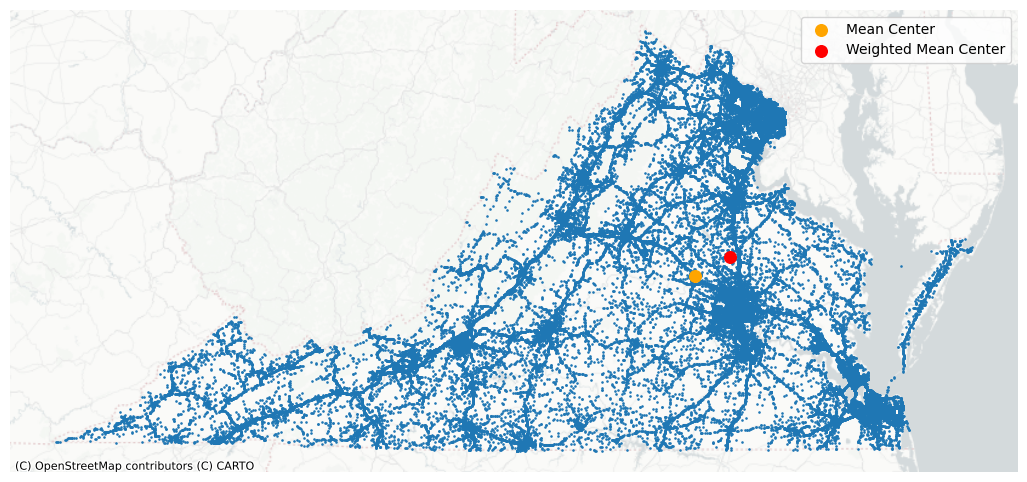

In [ ]:
# Setting up figure and axis
fig, ax = plt.subplots(figsize=(13, 6))

# Plotting the crash points
ax.scatter(x=crash.geometry.x, # extracting longitude from crash geometry
           y=crash.geometry.y, # extracting latitude from crash geometry,
           s=0.75)             # setting the size of the points

# Adding basemap from the contextily library (loaded as cx)
cx.add_basemap(
    ax =ax,
    crs="EPSG:3857",
    source=cx.providers.CartoDB.PositronNoLabels,
);

# adding mean center and weighted mean center
ax.scatter(*mean_center, color="orange", marker="o", s = 70, label="Mean Center")
ax.scatter(
    *wmc, color="red", marker="o", s = 70, label="Weighted Mean Center"
)

# show legend
ax.legend()
# Remove axes
ax.set_axis_off()

### Dispersion

Dispersion in centrography measures how **spread out the points are around the mean center**. Two key measures include:

**Standard Distance**

  Similar to standard deviation in statistics, this metric calculates the **variance in average distances of points from the mean center**. We can draw a standard distance circle to visualize the spread of events around the mean center.

**Standard Deviational Ellipse**

  Unlike the standard distance measure, this ellipse captures dispersion separately along the **major and minor axes**. It also provides information on **data orientation**, indicating **the direction in which most points are concentrated**. This orientation is measured as an **angle value (θ)**, representing the clockwise rotation of the ellipse.


In [ ]:
# calculating standard distance
std_dist = centrography.std_distance(long_lat)
print(std_dist)

193019.34165294605


In [ ]:
# calculating standard deviational Ellipse
major, minor, angle = centrography.ellipse(long_lat)
major, minor, angle

(155870.69371959593, 216768.59855282158, 1.390419141390434)

In the centrography module, this **angle is measured in radians**, so we need to convert it to degrees for proper visualization of the standard deviational ellipse.

In [ ]:
degree_angle = np.degrees(angle)
degree_angle

79.66514855587555

This indicates that the Standard Deviational Ellipse for the point pattern is rotated clockwise by  79.66∘ Now, let's plot it.

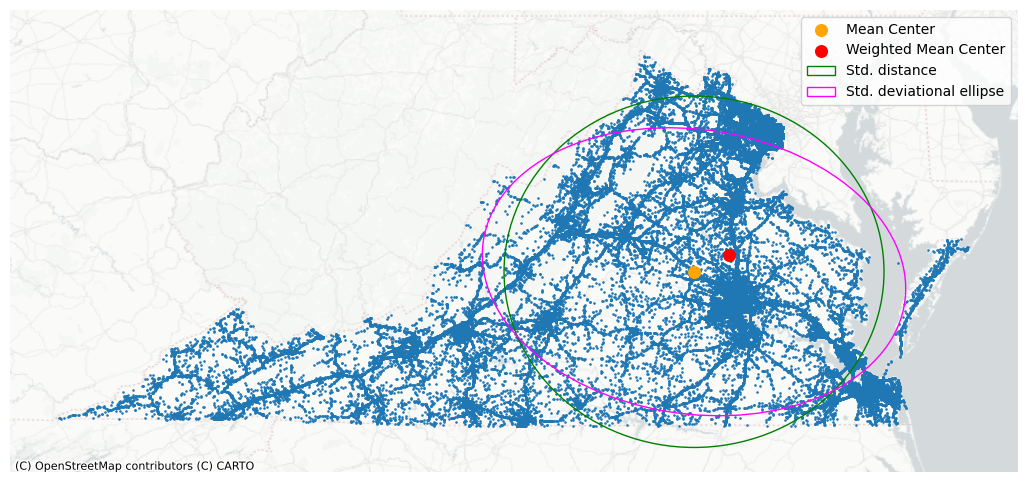

In [ ]:
# Setting up figure and axis
fig, ax = plt.subplots(figsize=(13, 6))

# Plotting the crash points
ax.scatter(x=crash.geometry.x, # extracting longitude from crash geometry
           y=crash.geometry.y, # extracting latitude from crash geometry,
           s=0.75)             # setting the size of the points

# Adding basemap from the contextily library (loaded as cx)
cx.add_basemap(
    ax =ax,
    crs="EPSG:3857",
    source=cx.providers.CartoDB.PositronNoLabels,
);

# adding mean center and weighted mean center
ax.scatter(*mean_center, color="orange", marker="o", s = 70, label="Mean Center")
ax.scatter(
    *wmc, color="red", marker="o", s = 70, label="Weighted Mean Center"
)

# adding std. distance circle
std_dist_circle = plt.Circle((mean_center[0], mean_center[1]),    # drawing circle around the mean center
                             std_dist,                            # using the standard distance as the circle radius
                             facecolor="none", edgecolor="green", # no fill color for the circle, outline color green
                             label="Std. distance")               # label to be used for legend

ax.add_artist(std_dist_circle)

# adding std. deviational ellipse
std_dev_ellipse = Ellipse(xy=mean_center,       # center the ellipse on the mean center
                          width=major * 2,      # centrography.ellipse only gives half the axis
                          height=minor * 2,     # centrography.ellipse only gives half the axis
                          angle= degree_angle,  # Angles need to be in degrees, not radians,
                          facecolor="none", edgecolor="magenta", # no fill color for the ellipse, outline color magenta
                          label="Std. deviational ellipse")      # label to be used for legend
ax.add_artist(std_dev_ellipse)

# show legend
ax.legend()

# adding/substracting value to give some margin around total bounds of base geometry
minx, miny, maxx, maxy = crash.geometry.total_bounds
ax.set_xlim(minx - 50000, maxx + 50000)
ax.set_ylim(miny - 50000, maxy + 50000)

# Remove axes
ax.set_axis_off()

### Extent

Geographic extent refers to the **minimum area that encloses all points in a dataset**. Two common methods for defining this extent include:

- **Minimum Bounding Rectangle (MBR):** The smallest rectangle that contains all points.
- **Convex Hull:** A tightly fitting convex shape enclosing all points.
These measures help define the overall spatial footprint of the point pattern.

In the following figure, the blue boundary is the Minimum Bounding Rectangle and the black boundary is the convex hull.

![image](https://i.sstatic.net/XgqRz.png)

In [ ]:
# estimating the convex hull vertices
convex_hull_vertices = centrography.hull(long_lat)
convex_hull_vertices

array([[-9198436.50528447,  4460704.93641437],
       [-9311593.13525278,  4383959.11228042],
       [-9309430.7219728 ,  4383461.26231714],
       [-8930649.84679989,  4376155.02280317],
       [-8846401.92100155,  4375070.1417828 ],
       [-8567866.3560131 ,  4375884.7660984 ],
       [-8564494.67186886,  4375918.56277838],
       [-8486122.9198297 ,  4376768.96039032],
       [-8468360.77631274,  4377023.32062007],
       [-8460975.28213572,  4378247.44427341],
       [-8451548.28623606,  4395730.37945751],
       [-8387989.6546405 ,  4572602.04143923],
       [-8395075.44880712,  4581123.35791039],
       [-8634291.05328238,  4762224.22339829],
       [-8650867.52633503,  4767593.36699931],
       [-8717886.69016793,  4782624.0107871 ]])

In [ ]:
# estimating the Minimum Bounding Rectangle
# output returned as min_x, min_y, max_x, max_y
min_rect_vertices = centrography.minimum_bounding_rectangle(long_lat)
min_rect_vertices

(-9311593.135252785, 4375070.141782797, -8387989.654640504, 4782624.0107871)

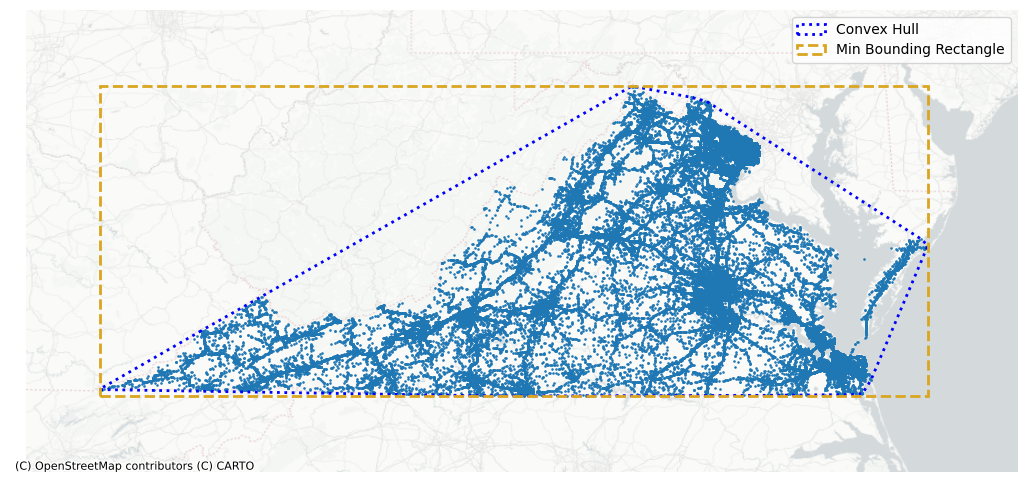

In [ ]:
# Setting up figure and axis
fig, ax = plt.subplots(figsize=(13, 6))

# Plotting the crash points
ax.scatter(x=crash.geometry.x, # extracting longitude from crash geometry
           y=crash.geometry.y, # extracting latitude from crash geometry,
           s=0.75)             # setting the size of the points

# Adding basemap from the contextily library (loaded as cx)
cx.add_basemap(
    ax =ax,
    crs="EPSG:3857",
    source=cx.providers.CartoDB.PositronNoLabels,
);

# Making a blue convex hull
convex_hull_patch = Polygon(
    convex_hull_vertices,
    closed=True,
    edgecolor="blue",
    facecolor="none",
    linestyle=":",
    linewidth=2,
    label="Convex Hull",
)


# compute the width and height of the minimum bounding rectangle
min_rect_x = min_rect_vertices[2] - min_rect_vertices[0]
min_rect_y = min_rect_vertices[3] - min_rect_vertices[1]

# Making a goldenrod minimum bounding rectangle
min_rect_patch = Rectangle(
    min_rect_vertices[0:2],
    width=min_rect_x,
    height=min_rect_y,
    edgecolor="goldenrod",
    facecolor="none",
    linestyle="dashed",
    linewidth=2,
    label="Min Bounding Rectangle",
)

# add the rest of the patches
ax.add_patch(convex_hull_patch)
ax.add_patch(min_rect_patch)


# show legend
ax.legend()

# adding/substracting value to give some margin around total bounds of base geometry
minx, miny, maxx, maxy = crash.geometry.total_bounds
ax.set_xlim(minx - 100000, maxx + 100000)
ax.set_ylim(miny - 100000, maxy + 100000)

# Remove axes
ax.set_axis_off()